In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-08 13:24:19.944347: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 13:24:25.618208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 13:24:28.462623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744118673.067701    1537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744118674.152031    1537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 13:24:38.169805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")


In [ ]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")

In [5]:
xgb_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.xgb_result.parquet")
xgb_results.set_index('date_hour', inplace=True)
xgb_results = xgb_results.drop("index", axis=1)

xgb_results

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
date_hour,,,,,,,,,,,,
2023-01-01 00:00:00,0.334815,0.121852,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189,0
2023-01-01 01:00:00,0.000000,-0.150000,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641,0
2023-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523,-1
2023-01-01 03:00:00,0.111605,-0.009383,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000,-1
2023-01-01 04:00:00,0.700000,0.000000,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,-0.00630797378946472641,-1
2024-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,0.00285821334903388110,-1
2024-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.00,0.000000,0.000000,0.000000,-0.00414167075852351572,-1


In [6]:
rfr_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/8.rfr_result.parquet")
rfr_results

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
17510,2023-01-01 00:00:00,0.334815,0.121852,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189,NaN
17511,2023-01-01 01:00:00,0.000000,-0.150000,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641,NaN
17512,2023-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523,NaN
17513,2023-01-01 03:00:00,0.111605,-0.009383,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000,NaN
17514,2023-01-01 04:00:00,0.700000,0.000000,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35049,2024-12-31 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,-0.00630797378946472641,NaN
35050,2024-12-31 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,0.00285821334903388110,NaN
35051,2024-12-31 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.00,0.000000,0.000000,0.000000,-0.00414167075852351572,NaN
35052,2024-12-31 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.00,0.000000,0.000000,0.000000,0.00093253585439578110,NaN


In [7]:
target_col = "target"

start_date = pd.to_datetime("2024-01-01 00:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,42652.0,42671.0,42569.0,42596.0,5.454452,-0.001385,-0.001008,165832.144886,42571.6,42540.3,...,57.808423,184.285112,198.428807,208.321905,42694.689248,42540.3,42385.910752,42794.749591,42428.05,42061.350409
2024-01-01 01:00:00,42600.0,42643.0,42500.0,42537.0,33.104355,-0.000729,-0.001385,165799.040531,42589.2,42528.8,...,54.964723,178.387239,194.469607,205.211338,42664.153758,42528.8,42393.446242,42805.195764,42437.85,42070.504236
2024-01-01 02:00:00,42537.0,42640.0,42506.0,42506.0,46.611812,-0.005929,-0.000729,165752.428719,42575.4,42529.3,...,53.476227,172.046205,190.150349,201.820322,42664.275701,42529.3,42394.324299,42801.283246,42454.80,42108.316754
2024-01-01 03:00:00,42506.0,42563.0,42096.0,42254.0,126.372266,0.000095,-0.005929,165626.056453,42506.4,42511.2,...,43.227930,214.182461,209.925324,214.447926,42720.166600,42511.2,42302.233400,42781.350675,42462.95,42144.549325
2024-01-01 04:00:00,42246.0,42332.0,42072.0,42258.0,66.348207,0.005017,0.000095,165692.404660,42430.2,42491.4,...,43.413304,220.727824,213.502087,216.617072,42749.322779,42491.4,42233.477221,42771.696518,42467.30,42162.903482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006


In [8]:
merged_df = pd.concat([price_indicator_2024, xgb_results], axis=1)
merged_df.drop("target",axis=1)
merged_df

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
date_hour,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005185,0.014815,0.033704,0.0,0.28,0.100000,0.095000,0.070833,-0.00012076565424793189,0
2023-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.350000,0.000000,0.500000,2.0,0.14,0.091667,0.101667,0.050417,-0.00096624192282142641,0
2023-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,1.0,0.00,0.056667,0.078333,0.046667,-0.00211569848274194523,-1
2023-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.114938,0.004938,0.177901,0.0,0.00,0.056667,0.078333,0.046667,0.00121153380179307000,-1
2023-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,1.0,0.14,0.080000,0.070000,0.055000,-0.00042352371732817038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,-0.00630797378946472641,-1
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0.000000,0.000000,0.000000,6.0,0.00,0.000000,0.000000,0.000000,0.00285821334903388110,-1
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0.000000,0.000000,0.000000,3.0,0.00,0.000000,0.000000,0.000000,-0.00414167075852351572,-1


# Statistical Feature Selection

In [9]:
train_start_date = pd.to_datetime("2024-01-01 00:00:00")
train_end_date = pd.to_datetime("2024-11-30 23:00:00")

test_start_date = pd.to_datetime("2024-12-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,Sentiment_24HR,target,signal
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-12-01 00:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.200000,0.000000,0.300000,4.0,0.020000,0.068333,0.082083,0.089792,-0.00208571132095050327,0
2024-12-01 01:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.000000,0.000000,0.800000,1.0,0.160000,0.090000,0.113333,0.100000,-0.00344185756324803211,1
2024-12-01 02:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.066667,0.000000,0.700000,0.0,0.160000,0.090000,0.113333,0.100000,0.00546755984056428560,1
2024-12-01 03:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.000000,0.266667,0.266667,3.0,0.126667,0.076667,0.105000,0.107222,0.00175380336647226080,1
2024-12-01 04:00:00,97510.0,97510.0,97482.0,97482.0,0.000000,0.000000,0.000000,174829.511397,97482.0,97482.0,...,0.000000,0.000000,0.000000,2.0,0.000000,0.113333,0.110833,0.124167,-0.00175073292517429634,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0.000000,0.000000,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,-0.00630797378946472641,-1
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0.000000,0.000000,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.00285821334903388110,-1
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0.000000,0.000000,0.000000,3.0,0.000000,0.000000,0.000000,0.000000,-0.00414167075852351572,-1


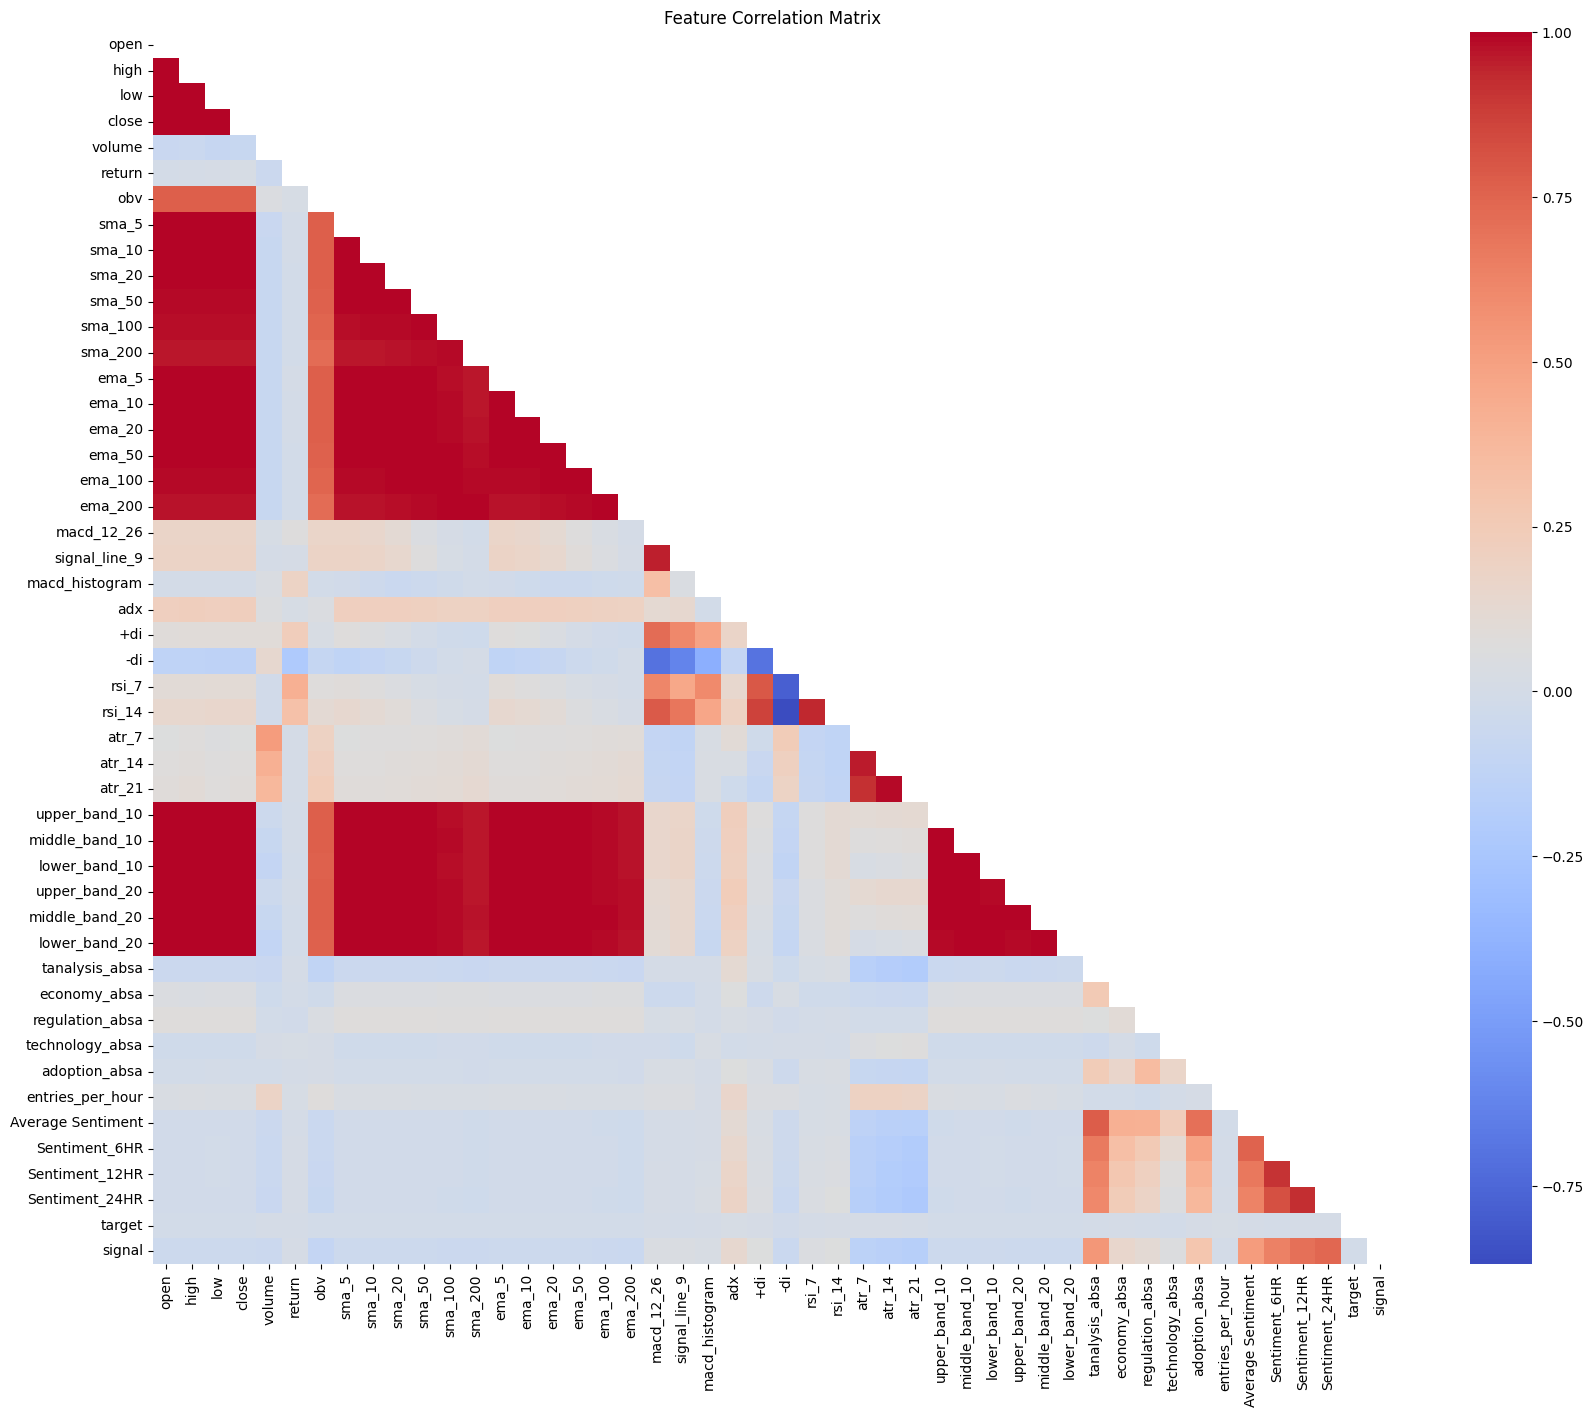

In [10]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [11]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 48 to 21
Top features selected: ['obv', 'sma_20', 'sma_100', 'sma_200', 'ema_100', 'ema_200', 'adx', '-di', 'lower_band_10', 'middle_band_20', 'lower_band_20', 'technology_absa', 'adoption_absa', 'entries_per_hour', 'target']


Index(['obv', 'sma_20', 'sma_100', 'sma_200', 'ema_100', 'ema_200', 'adx',
       '-di', 'lower_band_10', 'middle_band_20', 'lower_band_20',
       'technology_absa', 'adoption_absa', 'entries_per_hour', 'target'],
      dtype='object')

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[selected_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (17532, 12, 15)
y shape: (17532, 1)
Total sequences: 17532
Training sequences: 15778
Testing sequences: 1754


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

2025-04-08 13:24:46.565454: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: nan - val_loss: nan
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: nan - val_loss: nan
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: nan - val_loss: nan
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: nan - val_loss: nan
Epoch 9/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: nan - val_loss: nan
Epoch 10/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: nan - val_loss: nan
Epoch 11/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: nan - val_loss: nan
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Test Loss: nan
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

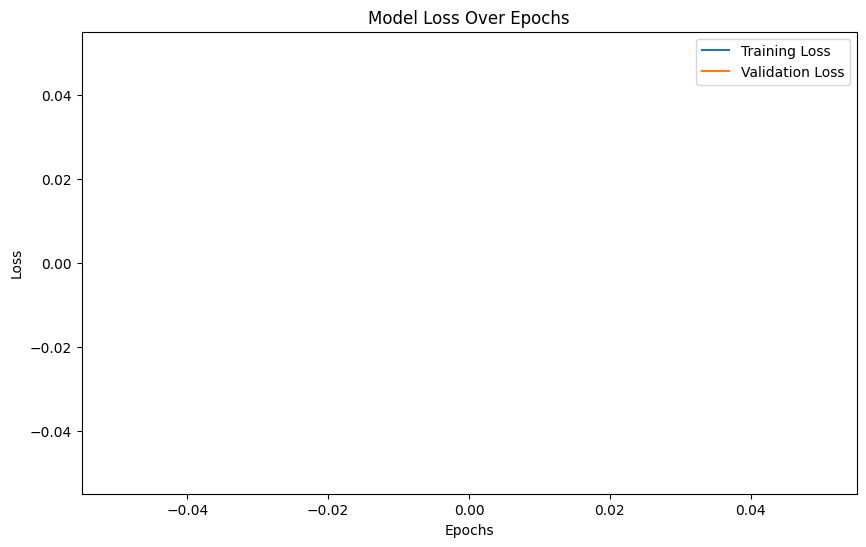

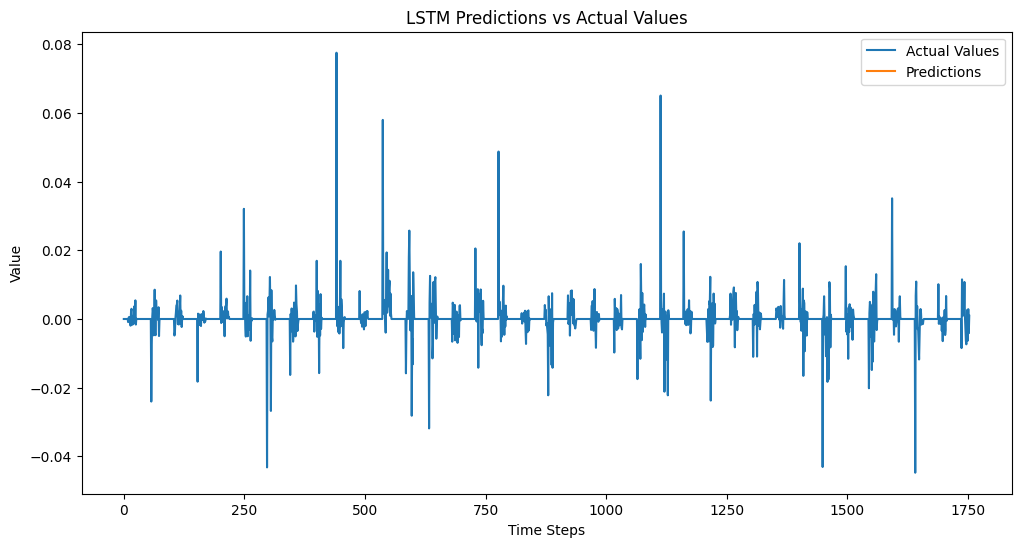

In [14]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)


In [16]:
model.save('sequential_selection_lstm_model.keras')  # HDF5 format


In [17]:
y_test

array([[0.36601665],
       [0.36601665],
       [0.36601665],
       ...,
       [0.38938859],
       [0.33214974],
       [0.3736421 ]])

In [18]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,Actual,Predicted
2024-10-19 22:00:00,0.000000,-0.004899
2024-10-19 23:00:00,0.000000,-0.004854
2024-10-20 00:00:00,0.000000,-0.004913
2024-10-20 01:00:00,0.000000,-0.004916
2024-10-20 02:00:00,0.000000,-0.004981
...,...,...
2024-12-31 19:00:00,0.002666,-0.005354
2024-12-31 20:00:00,-0.006308,-0.005494
2024-12-31 21:00:00,0.002858,-0.005560
2024-12-31 22:00:00,-0.004142,-0.005830


In [19]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.00001 else (-1 if x < -0.00001 else 0))
stat_signal_result_df

,Predicted,signal
2024-10-19 22:00:00,-0.004899,-1
2024-10-19 23:00:00,-0.004854,-1
2024-10-20 00:00:00,-0.004913,-1
2024-10-20 01:00:00,-0.004916,-1
2024-10-20 02:00:00,-0.004981,-1
...,...,...
2024-12-31 19:00:00,-0.005354,-1
2024-12-31 20:00:00,-0.005494,-1
2024-12-31 21:00:00,-0.005560,-1
2024-12-31 22:00:00,-0.005830,-1


Overall Annual Return: -84.73%
Overall Annual Sharpe Ratio: -3.3197
Maximum Drawdown: -41.85 %
Alpha: 0.0
Beta: -1.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.847296    0.524608         -1.0           0.0      -3.319703


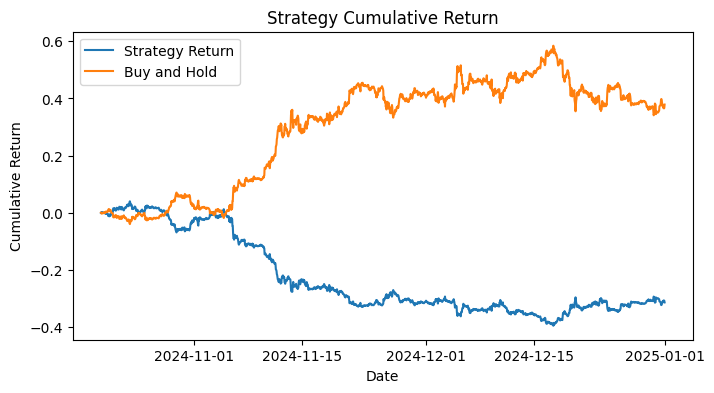

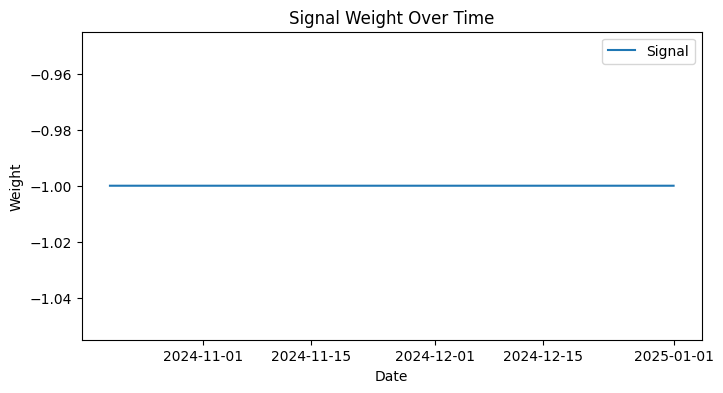

In [20]:
run_backtest(stat_signal_result_df)

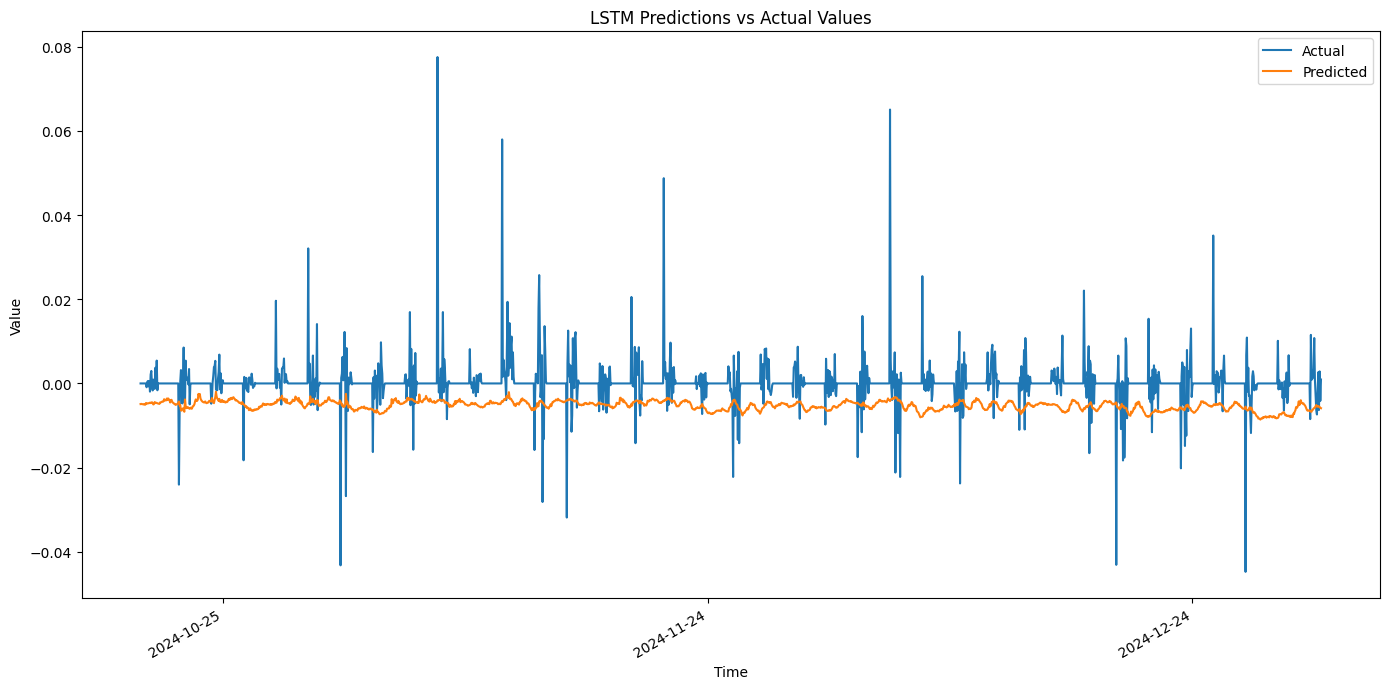

In [21]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[lstm_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (17532, 12, 15)
y shape: (17532, 1)
Total sequences: 17532
Training sequences: 15778
Testing sequences: 1754


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: nan - val_loss: nan
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: nan - val_loss: nan
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: nan - val_loss: nan
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: nan - val_loss: nan
Epoch 8/100
 72/395 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan

KeyboardInterrupt: 

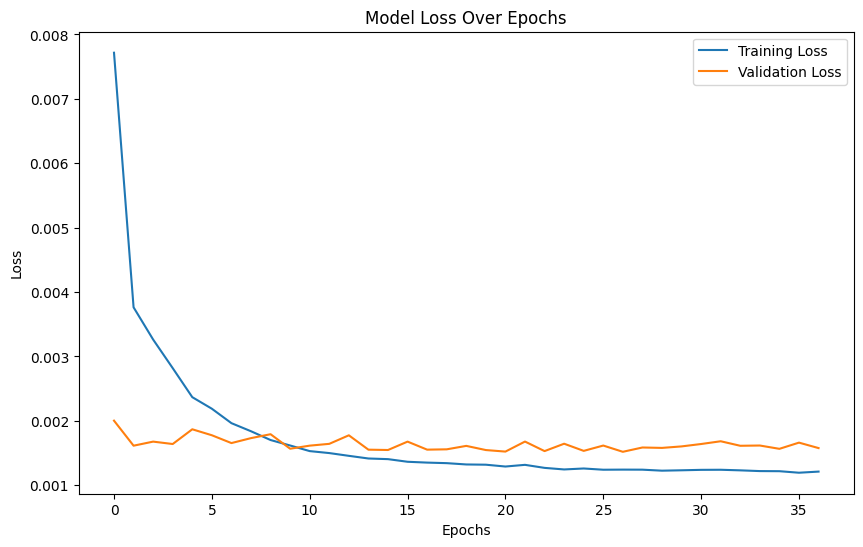

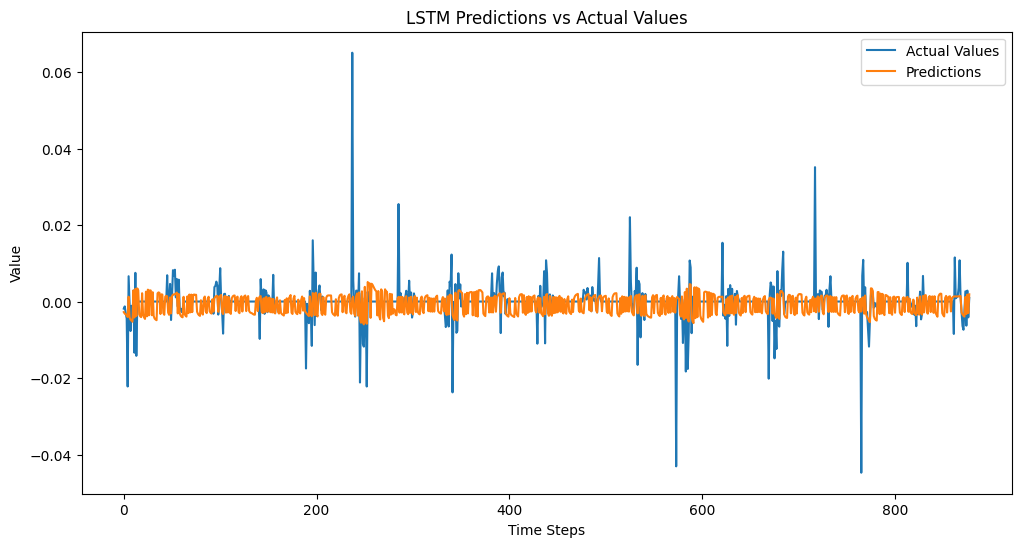

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

model.save('stat_features_selection_lstm_model.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.0001 else (-1 if x < -0.0001 else 0))
stat_signal_result_df

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Predicted,signal
2024-11-25 10:00:00,-0.002754,-1
2024-11-25 11:00:00,-0.003166,-1
2024-11-25 12:00:00,-0.003330,-1
2024-11-25 13:00:00,-0.003630,-1
2024-11-25 14:00:00,-0.004036,-1
...,...,...
2024-12-31 19:00:00,0.001211,1
2024-12-31 20:00:00,-0.003251,-1
2024-12-31 21:00:00,0.001814,1
2024-12-31 22:00:00,-0.002994,-1


Overall Annual Return: -85.32%
Overall Annual Sharpe Ratio: -3.2577
Maximum Drawdown: -28.98 %
Alpha: -0.8273
Beta: 0.0517

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.853237    0.543647      0.05168     -1.756157       -3.25766


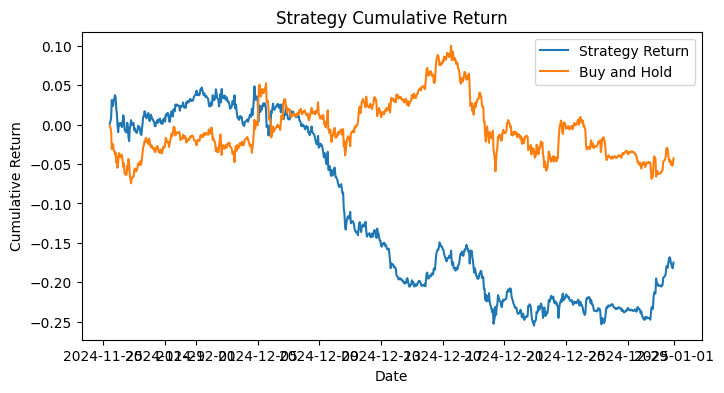

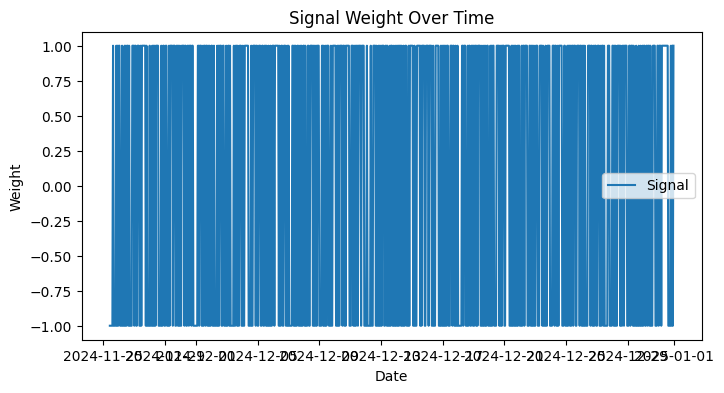

In [ ]:
run_backtest(stat_signal_result_df)